# Loading data & time conversion

In the TrainActivities.csv, all time-related columns are in JST but doesn't contain UTC information. 

While all accelerometer data are took in different time zones. 

Thus we need to add UTC information to activity labels dataset which is UTC+09:00

And convert all accelerometer data into the same timezone which is UTC+09:00

In [1]:
import pandas as pd
# load activity data
act_df = pd.read_csv('../data/TrainingDataPD25/TrainActivities.csv')
act_df.head()

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024/09/02 6:16,2024/09/02 6:16,2024/09/02 6:16,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:17,2024/09/02 6:17,2024/09/02 6:17,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:18,2024/09/02 6:18,2024/09/02 6:18,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024/09/02 6:20,2024/09/02 6:20,2024/09/02 6:20,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2


In [2]:
def convert_to_jst(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format='%Y/%m/%d %H:%M', errors='coerce')
        df[col] = df[col].dt.tz_localize('UTC+09:00')

cols = ['Started', 'Finished', 'Updated']
convert_to_jst(act_df, cols)

In [3]:
print(act_df['Started'].dt.tz)
display(act_df.head())

UTC+09:00


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2


In [4]:
"""
This dataset contains more than one timezones, but all of them include the UTC offset.
"""

# Load all csv files into one dataframe
import os
import glob
from datetime import timezone, timedelta

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'

headers = ['id', 'datetime', 'x', 'y', 'z']
df_list = [] # to store all csv files

for id in os.listdir(base_dir):
    path = os.path.join(base_dir, id)

    if os.path.isdir(path):
        files = glob.glob(os.path.join(path, '*.csv'))

        for f in files:
            df = pd.read_csv(f, header=None, names=headers) # load csv
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
            tz = df['datetime'].dt.tz # get the timezone
            if tz != 'UTC+09:00':
                df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
            df_list.append(df)

users_df = pd.concat(df_list, ignore_index=True)

In [5]:
users_df['datetime'].dt.tz

datetime.timezone(datetime.timedelta(seconds=32400))

In [6]:
users_df.head()

,id,datetime,x,y,z
0,2810,2024-09-10 06:25:37.059000+09:00,7.322,6.469,-0.548
1,2810,2024-09-10 06:25:37.075000+09:00,7.336,6.364,-0.586
2,2810,2024-09-10 06:25:37.084000+09:00,7.381,6.271,-0.612
3,2810,2024-09-10 06:25:37.093000+09:00,7.360,6.194,-0.624
4,2810,2024-09-10 06:25:37.102000+09:00,7.319,6.098,-0.619


# Matching activity labels with sensor data

In order to match the activity labels with the sensor data, we need to consider whether the timestamps in the sensor data are in the started and finished time of the activity or not. However, the started and finished in activity labels dataset do not contain any seconds, which makes no interval exists between started and finished.

Solution:
- Assume a activity started at H:min:00.000000 and finished at H:min:59.999999

In [5]:
act_df['started'] = act_df['Started'].dt.floor('s')
act_df['finished'] = act_df['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

In [6]:
cols = ['Started', 'Finished', 'started', 'finished']
act_df[cols].head()

,Started,Finished,started,finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00


In [7]:
# Clean up the dataset
print('number of na rows per columns:')
display(act_df.isna().sum())
cols = ['Activity Type', 'Started', 'Finished']
print(f'number of duplicated activity rows: {act_df.duplicated(subset=cols, keep='last').sum()}')
print(f'act_df shape: {act_df.shape}')

number of na rows per columns:


ID                   0
Activity Type ID     0
Activity Type        0
Started             66
Finished            67
Updated              0
Subject              0
started             66
finished            67
dtype: int64

number of duplicated activity rows: 128
act_df shape: (342, 9)


From the above, we can see that this dataset is really bad. We need to clean the na, and duplicated rows.

In [8]:
# drop na rows in act_df and sort by subject
# test_df = act_df.copy()
act_df = act_df.dropna()
cols = ['Activity Type', 'Started', 'Finished']
act_df = act_df.drop_duplicates(subset=cols, keep='last')
act_df = act_df.sort_values(by=['Subject', 'started'])

act_df = act_df.reset_index(drop=True)
print(f'act_df shape: {act_df.shape}')
display(act_df.head())
# del test_df

act_df shape: (203, 9)


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject,started,finished
0,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1,2024-09-02 06:44:00+09:00,2024-09-02 06:44:59.999999+09:00
1,1137246,2806,1 (FACING camera) Sit and stand,2024-09-03 21:21:00+09:00,2024-09-03 21:21:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:21:00+09:00,2024-09-03 21:21:59.999999+09:00
2,1137278,2806,1 (FACING camera) Sit and stand,2024-09-03 21:22:00+09:00,2024-09-03 21:22:00+09:00,2024-09-03 21:38:00+09:00,U1,2024-09-03 21:22:00+09:00,2024-09-03 21:22:59.999999+09:00
3,1137252,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 21:23:00+09:00,2024-09-03 21:23:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:23:00+09:00,2024-09-03 21:23:59.999999+09:00
4,1137255,2808,3 Stand up from chair - both hands with SHAKING,2024-09-03 21:24:00+09:00,2024-09-03 21:24:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:24:00+09:00,2024-09-03 21:24:59.999999+09:00


In [9]:
"""
Segmenting the dataset into one dataframe per activity
Description:
- Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.
"""
from datetime import timedelta

seg_label_list = [] # segment's (1 sample's) label list (label mean "activity_type_id", "user_id" etc.).
seg_list = [] # segment's (1 sample's) accelerometer data list.

for i in list(act_df.index):
    started_at = act_df.iloc[i]['started']
    finished_at = act_df.iloc[i]['finished']
    seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
    seg_label = act_df.iloc[i]['Activity Type']
    # check if seq is not empty
    if len(seg) != 0:
        seg_list.append(seg)
        seg_label_list.append(seg_label)

In [10]:
print(f'seg_list: {len(seg_list)}, seg_label_list: {len(seg_label_list)}')

seg_list: 199, seg_label_list: 199


# Exploring the data

#TODO: trying to plot each activity count per hours of a day

# Feature Extraction

In [11]:
print(f'Started date: {act_df['Started'].dt.date.min()}')
print(f'Finished date: {act_df['Started'].dt.date.max()}')

Started date: 2024-09-02
Finished date: 2024-09-11


From the above results, we can know that the year and month values are not important. So that, we can extract the date only then drop year and month

In [14]:
# tmp_df = act_df.copy()
# tmp_df['date'] = tmp_df['Started'].dt.hour
# tmp_df.sort_values(inplace=True, by='date', ignore_index=True)
# tmp_df['date']

In [12]:
import numpy as np
"""
Extracting std, mean, max and min from accelerometer data of each activity.

Returns:
    feats: List of features (which are std, mean, max, min)
Args:
    df: dataframe
Usages:
    feats_list = []
    for df in seg_list:
        feats_list.append(get_feats(df))
"""
# def get_feats(df, columns=['x', 'y', 'z']):
#     feats = []
#     for col in columns:
#         std_ = df[col].std(ddof=0)
#         mean_ = np.average(df[col])
#         max_ = np.max(df[col])
#         min_ = np.min(df[col])
#         feats.extend([std_, mean_, max_, min_])

#     return feats

import numpy as np
from scipy.stats import iqr, skew, kurtosis

def zero_crossing_rate(signal):
    """Calculate zero crossing rate of a 1D numpy array"""
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def get_feats(df, columns=['x', 'y', 'z']):
    feats = []

    # Time domain features per axis
    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)  # peak-to-peak (max - min)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, zcr_
        ])

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Correlation between axes
    corr_xy = df['x'].corr(df['y'])
    corr_yz = df['y'].corr(df['z'])
    corr_zx = df['z'].corr(df['x'])
    feats.extend([corr_xy, corr_yz, corr_zx])

    return feats


In [13]:
feats_list = []
for df in seg_list:
    feats_list.append(get_feats(df))

In [27]:
print(f'feats_list: {np.array(feats_list).shape}')

feats_list: (199, 40)


# Training

In [32]:
%pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Handling imbalanced data using SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
import numpy as np

# convert to np array
X = np.array(feats_list)
y = np.array(seg_label_list)

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'X: {X.shape}, y: {y.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (199, 40), y: (199,)
X_resampled: (270, 40), y_resampled: (270,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=4, stratify=y_resampled)

In [ ]:
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# y_train = np.array(y_train)

In [18]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f"X_test : {X_test.shape}, Y_test : {y_test.shape}")

X_train: (189, 40), y_train: (189,)
X_test : (81, 40), Y_test : (81,)


## LabelSpreading

In [35]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report

kernel_list = ['rbf', 'knn']
max_iter_list = [50, 100, 200, 300, 1000]
for ker in kernel_list:
    for it in max_iter_list:
        lspred = LabelSpreading(kernel=ker, alpha=0.5, max_iter=it)
        lspred.fit(X_train, y_train)
        # predict
        y_predict = lspred.predict(X_test)
        print(classification_report(y_test, y_predict))


                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.16      0.88      0.26         8
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       1.00      0.12      0.22         8
         2 (FACING camera) both hands SHAKING (sitting position)       0.00      0.00      0.00         8
                 3 Stand up from chair - both hands with SHAKING       0.33      0.12      0.18         8
                                         4 (Sideway) Sit & stand       0.00      0.00      0.00         8
                        5 (Sideway) both hands SHAKING (sitting)       0.50      0.38      0.43         8
                  6 (Sideway) STAND up with - both hands SHAKING       0.25      0.25      0.25         8
                                     7 Cool down - sitting/relax       0.50      0.11      0.18         9
                                8 Walk (LEFT 

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [ ]:
from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
# confusion_matrix(y_test, y_predict)

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.21      0.38      0.27         8
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.50      0.62      0.56         8
         2 (FACING camera) both hands SHAKING (sitting position)       0.33      0.25      0.29         8
                 3 Stand up from chair - both hands with SHAKING       0.60      0.75      0.67         8
                                         4 (Sideway) Sit & stand       0.40      0.25      0.31         8
                        5 (Sideway) both hands SHAKING (sitting)       0.64      0.88      0.74         8
                  6 (Sideway) STAND up with - both hands SHAKING       0.40      0.25      0.31         8
                                     7 Cool down - sitting/relax       0.50      0.11      0.18         9
                                8 Walk (LEFT 

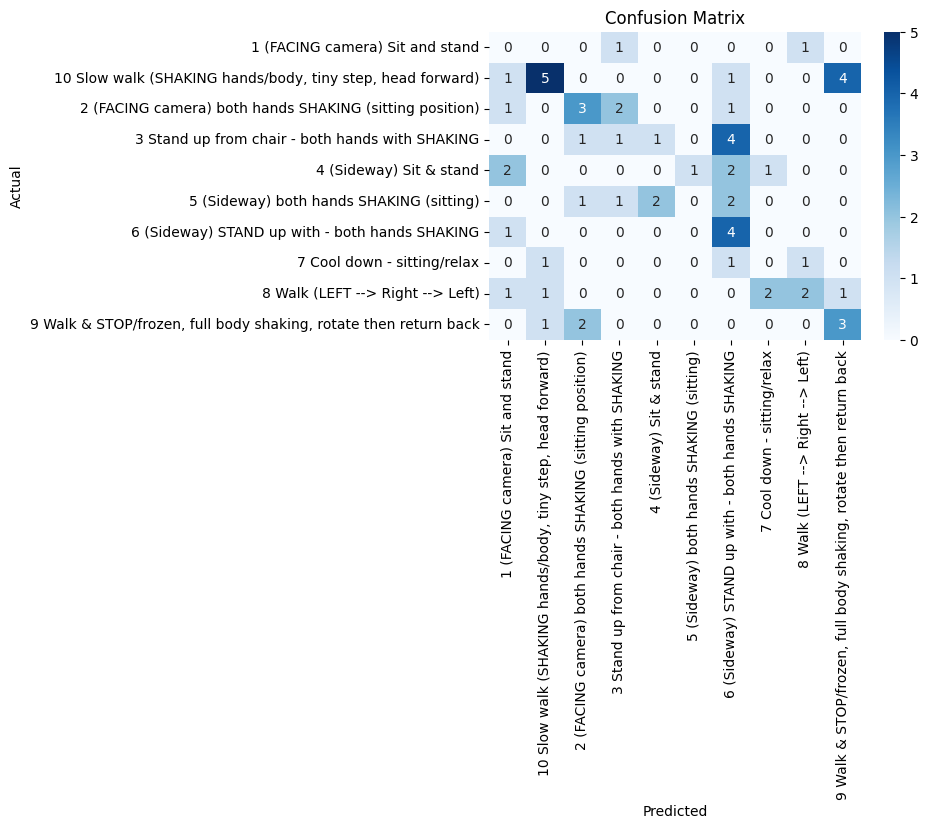

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# compute confusion matrix
cm = confusion_matrix(y_test, y_predict)
labels = np.unique(y_test)

# Plot with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ExtraTreesClassifier

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [29]:
etc.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))
# confusion_matrix(y_test, y_predict)

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.23      0.38      0.29         8
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.60      0.75      0.67         8
         2 (FACING camera) both hands SHAKING (sitting position)       0.33      0.25      0.29         8
                 3 Stand up from chair - both hands with SHAKING       0.55      0.75      0.63         8
                                         4 (Sideway) Sit & stand       0.40      0.25      0.31         8
                        5 (Sideway) both hands SHAKING (sitting)       0.67      0.75      0.71         8
                  6 (Sideway) STAND up with - both hands SHAKING       0.57      0.50      0.53         8
                                     7 Cool down - sitting/relax       0.67      0.22      0.33         9
                                8 Walk (LEFT 

# Deep Learning

## Convert to tensor

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [21]:
# Pastikan input adalah float dan label adalah integer
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (68, 12, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)    # (30, 12, 1)

# Encode label ke 0-9 jika belum
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LSTM

In [67]:
class DeepBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=10, dropout=0.3):
        super(DeepBiLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size * 4),  # *2 karena bidirectional
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # output: (batch, seq_len, hidden*2)
        out = lstm_out[:, -1, :]    # Ambil output timestep terakhir
        return self.mlp(out)

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBiLSTMClassifier(
            input_size=X_train_tensor.shape[2],  # atau 12
            hidden_size=32,
            num_layers=2,
            num_classes=10,
            dropout=0.35
        ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/1000, Loss: 2.2860
Epoch 2/1000, Loss: 2.2627
Epoch 3/1000, Loss: 2.3044
Epoch 4/1000, Loss: 2.3226
Epoch 5/1000, Loss: 2.3033
Epoch 6/1000, Loss: 2.3137
Epoch 7/1000, Loss: 2.3518
Epoch 8/1000, Loss: 2.3345
Epoch 9/1000, Loss: 2.3303
Epoch 10/1000, Loss: 2.3046
Epoch 11/1000, Loss: 2.2649
Epoch 12/1000, Loss: 2.3036
Epoch 13/1000, Loss: 2.2973
Epoch 14/1000, Loss: 2.3203
Epoch 15/1000, Loss: 2.2933
Epoch 16/1000, Loss: 2.3015
Epoch 17/1000, Loss: 2.2615
Epoch 18/1000, Loss: 2.2788
Epoch 19/1000, Loss: 2.3028
Epoch 20/1000, Loss: 2.2432
Epoch 21/1000, Loss: 2.3402
Epoch 22/1000, Loss: 2.2966
Epoch 23/1000, Loss: 2.2873
Epoch 24/1000, Loss: 2.2881
Epoch 25/1000, Loss: 2.3297
Epoch 26/1000, Loss: 2.2858
Epoch 27/1000, Loss: 2.2955
Epoch 28/1000, Loss: 2.2687
Epoch 29/1000, Loss: 2.2712
Epoch 30/1000, Loss: 2.2673
Epoch 31/1000, Loss: 2.3039
Epoch 32/1000, Loss: 2.3110
Epoch 33/1000, Loss: 2.2845
Epoch 34/1000, Loss: 2.2883
Epoch 35/1000, Loss: 2.3014
Epoch 36/1000, Loss: 2.2931
E

In [69]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.05      0.33      0.08         3
     Class 1       0.31      1.00      0.48         5
     Class 2       0.10      0.14      0.12         7
     Class 3       0.00      0.00      0.00         4
     Class 4       0.00      0.00      0.00         9
     Class 5       0.00      0.00      0.00         8
     Class 6       0.20      0.29      0.24         7
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00         5
     Class 9       0.00      0.00      0.00         9

    accuracy                           0.15        60
   macro avg       0.07      0.18      0.09        60
weighted avg       0.06      0.15      0.08        60



## Transformer

In [24]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=2, num_classes=10, dropout=0.25):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model*4),
            # nn.GELU(),
            
            # nn.LayerNorm(d_model*4),
            # nn.Linear(d_model*4, d_model),
            # nn.Dropout(0.2),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim) → (16, 12, 1)
        x = self.input_projection(x)       # → (16, 12, d_model)
        x = self.pos_encoder(x)            # positional encoding
        x = x.transpose(0, 1)              # → (seq_len, batch, d_model)
        x = self.transformer_encoder(x)    # → (seq_len, batch, d_model)
        x = x.mean(dim=0)                  # mean pooling over time steps → (batch, d_model)
        return self.classifier(x)          # → (batch, num_classes)

In [25]:
from torch.optim.lr_scheduler import OneCycleLR

model = TransformerClassifier(
            input_dim=1, 
            d_model=128, 
            nhead=4, 
            num_layers=2, 
            num_classes=10,
            dropout=0.2
        ).to(device)

num_epochs = 200
max_lr = 0.000357
clip_value = 1.5
steps_per_epoch = len(train_loader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)


scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.3,  # % of total steps to increase the LR
    anneal_strategy='cos',  # cosine annealing after max_lr
    div_factor=25.0,  # initial_lr = max_lr / div_factor
    final_div_factor=1e4  # final_lr = initial_lr / final_div_factor
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()  # Step the OneCycle scheduler

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / steps_per_epoch:.4f}")

/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 2.4827
Epoch 2/200, Loss: 2.3966
Epoch 3/200, Loss: 2.3343
Epoch 4/200, Loss: 2.2881
Epoch 5/200, Loss: 2.2630
Epoch 6/200, Loss: 2.2652
Epoch 7/200, Loss: 2.2487
Epoch 8/200, Loss: 2.2309
Epoch 9/200, Loss: 2.2091
Epoch 10/200, Loss: 2.1990
Epoch 11/200, Loss: 2.1903
Epoch 12/200, Loss: 2.1805
Epoch 13/200, Loss: 2.1763
Epoch 14/200, Loss: 2.1768
Epoch 15/200, Loss: 2.1560
Epoch 16/200, Loss: 2.1579
Epoch 17/200, Loss: 2.1510
Epoch 18/200, Loss: 2.1395
Epoch 19/200, Loss: 2.1284
Epoch 20/200, Loss: 2.1215
Epoch 21/200, Loss: 2.1165
Epoch 22/200, Loss: 2.1128
Epoch 23/200, Loss: 2.0874
Epoch 24/200, Loss: 2.1424
Epoch 25/200, Loss: 2.1015
Epoch 26/200, Loss: 2.0950
Epoch 27/200, Loss: 2.0953
Epoch 28/200, Loss: 2.0581
Epoch 29/200, Loss: 2.0652
Epoch 30/200, Loss: 2.0366
Epoch 31/200, Loss: 1.9874
Epoch 32/200, Loss: 2.0003
Epoch 33/200, Loss: 2.0362
Epoch 34/200, Loss: 2.0715
Epoch 35/200, Loss: 2.0545
Epoch 36/200, Loss: 2.0402
Epoch 37/200, Loss: 1.9769
Epoch 38/2

In [26]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.17      0.25      0.20         8
     Class 1       1.00      0.50      0.67         8
     Class 2       0.25      0.12      0.17         8
     Class 3       0.75      0.38      0.50         8
     Class 4       0.38      0.38      0.38         8
     Class 5       0.17      0.12      0.14         8
     Class 6       0.33      0.38      0.35         8
     Class 7       0.42      0.56      0.48         9
     Class 8       0.38      0.62      0.48         8
     Class 9       0.33      0.38      0.35         8

    accuracy                           0.37        81
   macro avg       0.42      0.37      0.37        81
weighted avg       0.42      0.37      0.37        81



# Experimenting with Lazy Predict

In [ ]:
%pip install lazypredict
%pip install ipywidgets

  Using cached importlib_metadata-8.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached zipp-3.21.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.0 MB/s eta 0:00:003.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 3.6 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.

In [31]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2466
[LightGBM] [Info] Number of data points in the train set: 189, number of used features: 40
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.351375
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Info] Start training from score -2.297308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No